In [1]:
import joblib
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, KFold, cross_val_predict, cross_validate
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc
import pandas as pd
import time

def random_forest(art_name, method, save_model=False):

    ####################
    # TRAINING
    ####################

    arts = ['art_nouveau', 'baroque', 'expressionism', 'impressionism', 'post_impressionism', 'realism', 'renaissance', 'romanticism', 'surrealism', 'ukiyo-e']
    paths_train = []
    
    if art_name == 'all':
        for art in arts:
            path_fake_train = f'csv/art_{method}/train/AI_SD_{art}.csv'
            path_real_train = f'csv/art_{method}/train/{art}.csv'
            paths_train.extend([path_fake_train, path_real_train])
    else:
        path_fake_train = f'csv/art_{method}/train/AI_SD_{art_name}.csv'
        path_real_train = f'csv/art_{method}/train/{art_name}.csv'
        paths_train = [path_fake_train, path_real_train]

    # Get data
    data_train = pd.concat([pd.read_csv(path, header=0) for path in paths_train], ignore_index=True)
    X_train = data_train.iloc[:, :-1]
    y_train = data_train.iloc[:, -1]

    # Define Random Forest
    rf = RandomForestClassifier(n_estimators=100)

    # kcross validation
    kf = KFold(n_splits=10, shuffle=True)
    scoring = ['accuracy', 'precision', 'recall', 'f1']
    cv_results = cross_validate(rf, X_train, y_train, cv=kf, scoring=scoring)
    
    # Results
    accuracy_mean = cv_results['test_accuracy'].mean()
    accuracy_std = cv_results['test_accuracy'].std()
    
    precision_mean = cv_results['test_precision'].mean()
    precision_std = cv_results['test_precision'].std()
    
    recall_mean = cv_results['test_recall'].mean()
    recall_std = cv_results['test_recall'].std()
    
    f1_mean = cv_results['test_f1'].mean()
    f1_std = cv_results['test_f1'].std()

    # Train model
    start_train = time.time()
    rf.fit(X_train, y_train)
    end_train = time.time()
    train_time = end_train - start_train

    if save_model:
        joblib.dump(rf, f'models/{art_name}_{method}.pkl')
    
    ####################
    # TEST
    ####################

    paths_test = []
    n_images_test = 0

    if art_name == 'all':
        for art in arts:
            path_fake_test = f'csv/art_{method}/test/AI_SD_{art}.csv'
            path_real_test = f'csv/art_{method}/test/{art}.csv'
            paths_test.extend([path_fake_test, path_real_test])
        n_images_test = 20000
    else:
        path_fake_test = f'csv/art_{method}/test/AI_SD_{art_name}.csv'    
        path_real_test = f'csv/art_{method}/test/{art_name}.csv'
        paths_test = [path_fake_test, path_real_test]
        n_images_test = 2000

    data_test = pd.concat([pd.read_csv(path, header=0) for path in paths_test], ignore_index=True)
    X_test = data_test.iloc[:, :-1]
    y_test = data_test.iloc[:, -1]

    # Predict
    start_test = time.time()
    y_test_pred = rf.predict(X_test)
    end_test = time.time()
    test_time = (end_test - start_test) * 1000 / n_images_test # Inference per image in ms
    test_accuracy = accuracy_score(y_test, y_test_pred)
    test_precision = precision_score(y_test, y_test_pred)
    test_recall = recall_score(y_test, y_test_pred)
    test_f1 = f1_score(y_test, y_test_pred)

    # ROC curve and AUC
    y_probs = rf.predict_proba(X_test)[:,1]
    fpr, tpr, thresholds = roc_curve(y_test, y_probs)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(6, 4.5))
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.title('ROC curve')
    plt.legend(loc='lower right')
    plt.grid()
    plt.show()
    
    # Print metrics
    print('Cross-Validation')
    print(f"Accuracy: {accuracy_mean:.4f} ± {accuracy_std:.4f}")
    print(f"Precision: {precision_mean:.4f} ± {precision_std:.4f}")
    print(f"Recall: {recall_mean:.4f} ± {recall_std:.4f}")
    print(f"F1 Score: {f1_mean:.4f} ± {f1_std:.4f}")
    print(f"Latex: {art_name}\_{method} & {accuracy_mean:.4f} ± {accuracy_std:.4f} & {precision_mean:.4f} ± {precision_std:.4f} & {recall_mean:.4f} ± {recall_std:.4f} & {f1_mean:.4f} ± {f1_std:.4f} \\\\ \hline")
    
    print('\nTest')
    print(f"Accuracy: {test_accuracy:.4f}")
    print(f"Precision: {test_precision:.4f}")
    print(f"Recall: {test_recall:.4f}")
    print(f"F1 Score: {test_f1:.4f}")
    print(f"AUC: {roc_auc:.4f}")
    print(f"Latex: {art_name}\_{method} & {test_accuracy:.4f} & {test_precision:.4f} & {test_recall:.4f} & {test_f1:.4f} & {roc_auc:.4f} \\\\ \hline")
    
    print('\nTimes')
    print(f"Train time: {train_time:.4f} seconds")
    print(f"Test time: {test_time:.4f} miliseconds")
    print(f"Latex: {art_name}\_{method} & {train_time:.4f} & {test_time:.4f} \\\\ \hline")


# nq2 METHOD #

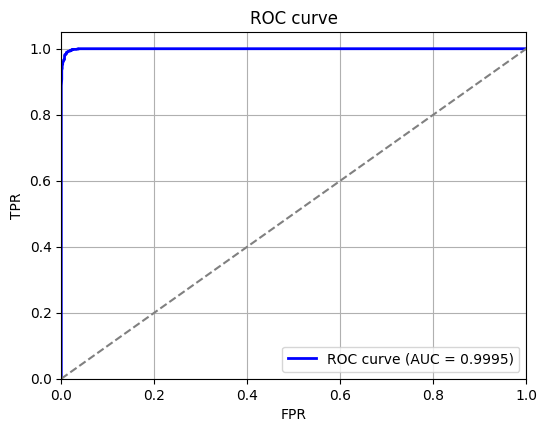

Cross-Validation
Accuracy: 0.9896 ± 0.0034
Precision: 0.9880 ± 0.0046
Recall: 0.9920 ± 0.0029
F1 Score: 0.9900 ± 0.0032
Latex: art_nouveau\_nq2 & 0.9896 ± 0.0034 & 0.9880 ± 0.0046 & 0.9920 ± 0.0029 & 0.9900 ± 0.0032 \\ \hline

Test
Accuracy: 0.9865
Precision: 0.9793
Recall: 0.9940
F1 Score: 0.9866
AUC: 0.9995
Latex: art_nouveau\_nq2 & 0.9865 & 0.9793 & 0.9940 & 0.9866 & 0.9995 \\ \hline

Times
Train time: 4.8197 seconds
Test time: 0.0060 miliseconds
Latex: art_nouveau\_nq2 & 4.8197 & 0.0060 \\ \hline


In [2]:
random_forest('art_nouveau', 'nq2')

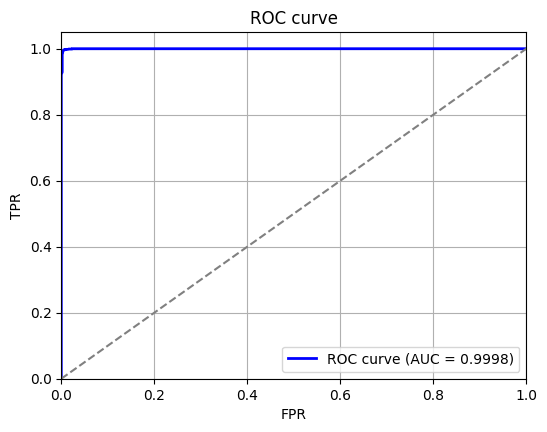

Cross-Validation
Accuracy: 0.9934 ± 0.0033
Precision: 0.9904 ± 0.0054
Recall: 0.9966 ± 0.0022
F1 Score: 0.9935 ± 0.0033
Latex: baroque\_nq2 & 0.9934 ± 0.0033 & 0.9904 ± 0.0054 & 0.9966 ± 0.0022 & 0.9935 ± 0.0033 \\ \hline

Test
Accuracy: 0.9915
Precision: 0.9842
Recall: 0.9990
F1 Score: 0.9916
AUC: 0.9998
Latex: baroque\_nq2 & 0.9915 & 0.9842 & 0.9990 & 0.9916 & 0.9998 \\ \hline

Times
Train time: 4.7973 seconds
Test time: 0.0055 miliseconds
Latex: baroque\_nq2 & 4.7973 & 0.0055 \\ \hline


In [3]:
random_forest('baroque', 'nq2')

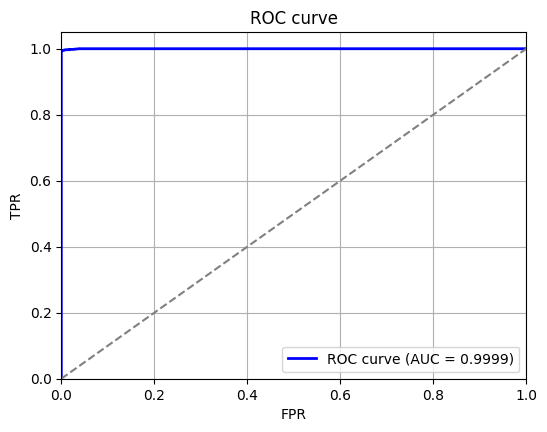

Cross-Validation
Accuracy: 0.9975 ± 0.0019
Precision: 0.9966 ± 0.0031
Recall: 0.9985 ± 0.0017
F1 Score: 0.9975 ± 0.0019
Latex: expressionism\_nq2 & 0.9975 ± 0.0019 & 0.9966 ± 0.0031 & 0.9985 ± 0.0017 & 0.9975 ± 0.0019 \\ \hline

Test
Accuracy: 0.9965
Precision: 1.0000
Recall: 0.9930
F1 Score: 0.9965
AUC: 0.9999
Latex: expressionism\_nq2 & 0.9965 & 1.0000 & 0.9930 & 0.9965 & 0.9999 \\ \hline

Times
Train time: 4.4600 seconds
Test time: 0.0051 miliseconds
Latex: expressionism\_nq2 & 4.4600 & 0.0051 \\ \hline


In [4]:
random_forest('expressionism', 'nq2')

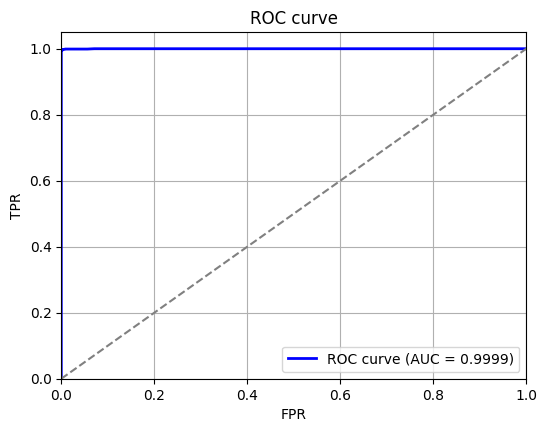

Cross-Validation
Accuracy: 0.9964 ± 0.0015
Precision: 0.9966 ± 0.0017
Recall: 0.9965 ± 0.0023
F1 Score: 0.9966 ± 0.0014
Latex: impressionism\_nq2 & 0.9964 ± 0.0015 & 0.9966 ± 0.0017 & 0.9965 ± 0.0023 & 0.9966 ± 0.0014 \\ \hline

Test
Accuracy: 0.9970
Precision: 0.9990
Recall: 0.9950
F1 Score: 0.9970
AUC: 0.9999
Latex: impressionism\_nq2 & 0.9970 & 0.9990 & 0.9950 & 0.9970 & 0.9999 \\ \hline

Times
Train time: 2.6241 seconds
Test time: 0.0047 miliseconds
Latex: impressionism\_nq2 & 2.6241 & 0.0047 \\ \hline


In [5]:
random_forest('impressionism', 'nq2')

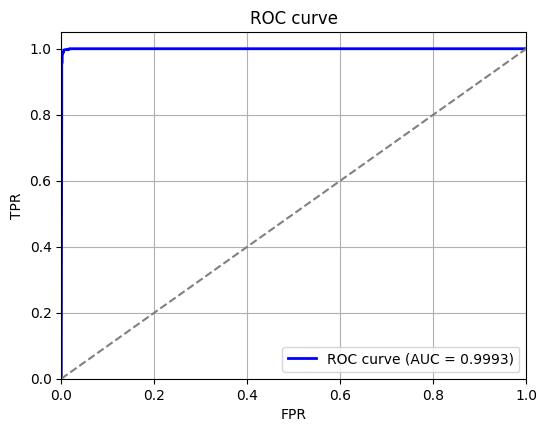

Cross-Validation
Accuracy: 0.9949 ± 0.0023
Precision: 0.9927 ± 0.0033
Recall: 0.9974 ± 0.0021
F1 Score: 0.9950 ± 0.0023
Latex: post_impressionism\_nq2 & 0.9949 ± 0.0023 & 0.9927 ± 0.0033 & 0.9974 ± 0.0021 & 0.9950 ± 0.0023 \\ \hline

Test
Accuracy: 0.9930
Precision: 0.9891
Recall: 0.9970
F1 Score: 0.9930
AUC: 0.9993
Latex: post_impressionism\_nq2 & 0.9930 & 0.9891 & 0.9970 & 0.9930 & 0.9993 \\ \hline

Times
Train time: 4.6851 seconds
Test time: 0.0049 miliseconds
Latex: post_impressionism\_nq2 & 4.6851 & 0.0049 \\ \hline


In [6]:
random_forest('post_impressionism', 'nq2')

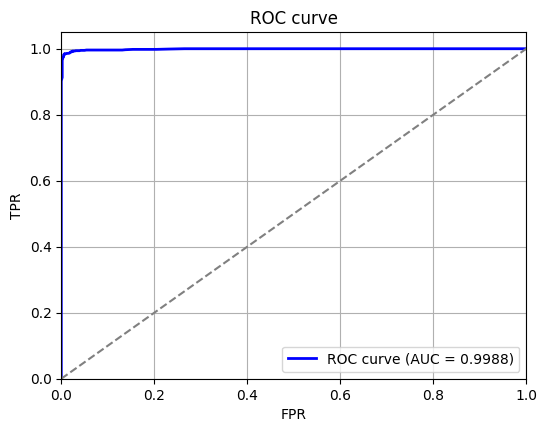

Cross-Validation
Accuracy: 0.9820 ± 0.0056
Precision: 0.9824 ± 0.0080
Recall: 0.9827 ± 0.0038
F1 Score: 0.9825 ± 0.0052
Latex: realism\_nq2 & 0.9820 ± 0.0056 & 0.9824 ± 0.0080 & 0.9827 ± 0.0038 & 0.9825 ± 0.0052 \\ \hline

Test
Accuracy: 0.9850
Precision: 0.9831
Recall: 0.9870
F1 Score: 0.9850
AUC: 0.9988
Latex: realism\_nq2 & 0.9850 & 0.9831 & 0.9870 & 0.9850 & 0.9988 \\ \hline

Times
Train time: 5.2981 seconds
Test time: 0.0071 miliseconds
Latex: realism\_nq2 & 5.2981 & 0.0071 \\ \hline


In [7]:
random_forest('realism', 'nq2')

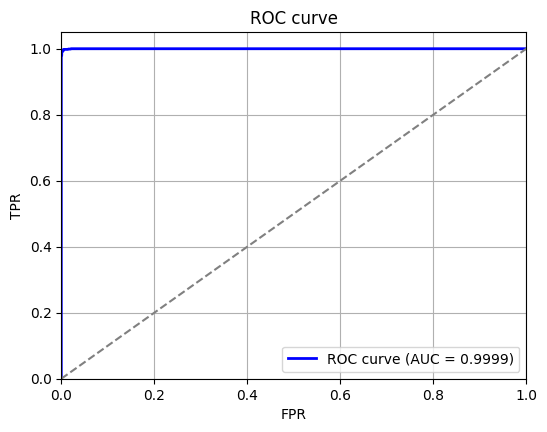

Cross-Validation
Accuracy: 0.9949 ± 0.0010
Precision: 0.9927 ± 0.0021
Recall: 0.9972 ± 0.0022
F1 Score: 0.9950 ± 0.0010
Latex: renaissance\_nq2 & 0.9949 ± 0.0010 & 0.9927 ± 0.0021 & 0.9972 ± 0.0022 & 0.9950 ± 0.0010 \\ \hline

Test
Accuracy: 0.9940
Precision: 0.9901
Recall: 0.9980
F1 Score: 0.9940
AUC: 0.9999
Latex: renaissance\_nq2 & 0.9940 & 0.9901 & 0.9980 & 0.9940 & 0.9999 \\ \hline

Times
Train time: 4.5437 seconds
Test time: 0.0052 miliseconds
Latex: renaissance\_nq2 & 4.5437 & 0.0052 \\ \hline


In [8]:
random_forest('renaissance', 'nq2')

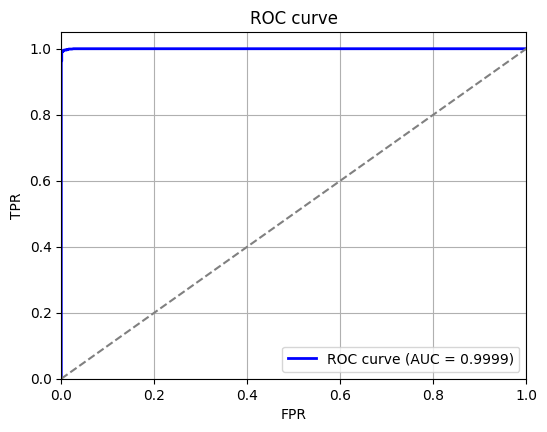

Cross-Validation
Accuracy: 0.9967 ± 0.0013
Precision: 0.9960 ± 0.0016
Recall: 0.9976 ± 0.0018
F1 Score: 0.9968 ± 0.0012
Latex: romanticism\_nq2 & 0.9967 ± 0.0013 & 0.9960 ± 0.0016 & 0.9976 ± 0.0018 & 0.9968 ± 0.0012 \\ \hline

Test
Accuracy: 0.9940
Precision: 0.9950
Recall: 0.9930
F1 Score: 0.9940
AUC: 0.9999
Latex: romanticism\_nq2 & 0.9940 & 0.9950 & 0.9930 & 0.9940 & 0.9999 \\ \hline

Times
Train time: 4.3655 seconds
Test time: 0.0049 miliseconds
Latex: romanticism\_nq2 & 4.3655 & 0.0049 \\ \hline


In [9]:
random_forest('romanticism', 'nq2')

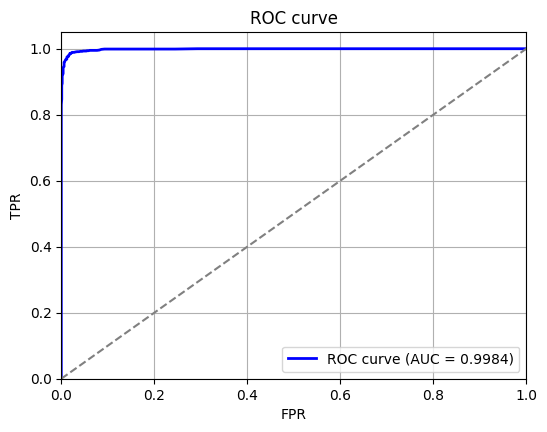

Cross-Validation
Accuracy: 0.9804 ± 0.0040
Precision: 0.9810 ± 0.0036
Recall: 0.9813 ± 0.0067
F1 Score: 0.9811 ± 0.0037
Latex: surrealism\_nq2 & 0.9804 ± 0.0040 & 0.9810 ± 0.0036 & 0.9813 ± 0.0067 & 0.9811 ± 0.0037 \\ \hline

Test
Accuracy: 0.9815
Precision: 0.9869
Recall: 0.9760
F1 Score: 0.9814
AUC: 0.9984
Latex: surrealism\_nq2 & 0.9815 & 0.9869 & 0.9760 & 0.9814 & 0.9984 \\ \hline

Times
Train time: 4.0901 seconds
Test time: 0.0078 miliseconds
Latex: surrealism\_nq2 & 4.0901 & 0.0078 \\ \hline


In [10]:
random_forest('surrealism', 'nq2')

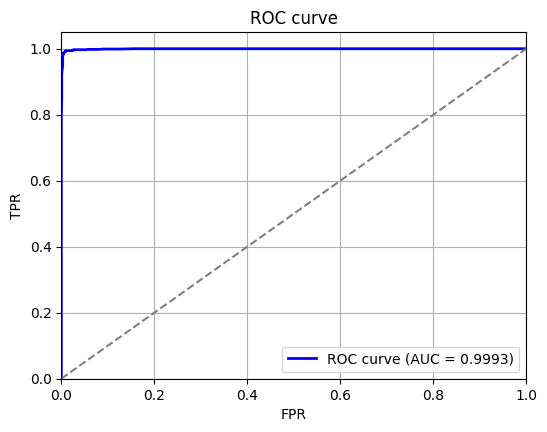

Cross-Validation
Accuracy: 0.9937 ± 0.0019
Precision: 0.9914 ± 0.0030
Recall: 0.9964 ± 0.0030
F1 Score: 0.9939 ± 0.0019
Latex: ukiyo-e\_nq2 & 0.9937 ± 0.0019 & 0.9914 ± 0.0030 & 0.9964 ± 0.0030 & 0.9939 ± 0.0019 \\ \hline

Test
Accuracy: 0.9920
Precision: 0.9910
Recall: 0.9930
F1 Score: 0.9920
AUC: 0.9993
Latex: ukiyo-e\_nq2 & 0.9920 & 0.9910 & 0.9930 & 0.9920 & 0.9993 \\ \hline

Times
Train time: 4.1303 seconds
Test time: 0.0056 miliseconds
Latex: ukiyo-e\_nq2 & 4.1303 & 0.0056 \\ \hline


In [11]:
random_forest('ukiyo-e', 'nq2')

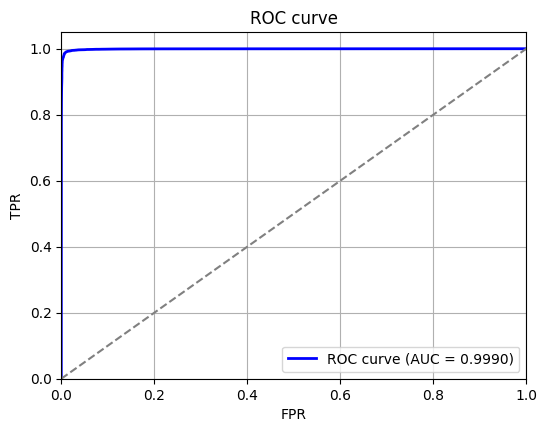

Cross-Validation
Accuracy: 0.9893 ± 0.0010
Precision: 0.9892 ± 0.0018
Recall: 0.9900 ± 0.0012
F1 Score: 0.9896 ± 0.0010
Latex: all\_nq2 & 0.9893 ± 0.0010 & 0.9892 ± 0.0018 & 0.9900 ± 0.0012 & 0.9896 ± 0.0010 \\ \hline

Test
Accuracy: 0.9899
Precision: 0.9894
Recall: 0.9903
F1 Score: 0.9899
AUC: 0.9990
Latex: all\_nq2 & 0.9899 & 0.9894 & 0.9903 & 0.9899 & 0.9990 \\ \hline

Times
Train time: 81.3895 seconds
Test time: 0.0064 miliseconds
Latex: all\_nq2 & 81.3895 & 0.0064 \\ \hline


In [12]:
random_forest('all', 'nq2')

# ref METHOD #

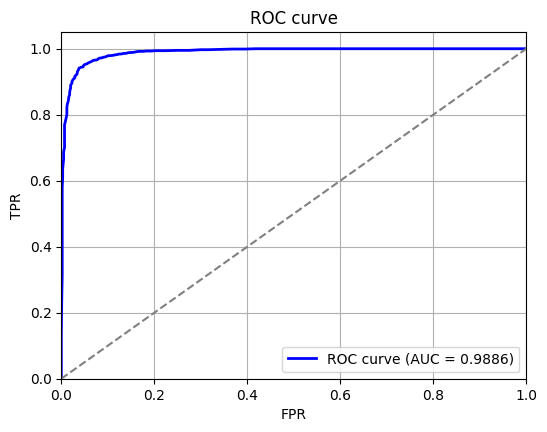

Cross-Validation
Accuracy: 0.9447 ± 0.0084
Precision: 0.9421 ± 0.0080
Recall: 0.9521 ± 0.0110
F1 Score: 0.9470 ± 0.0077
Latex: art_nouveau\_ref & 0.9447 ± 0.0084 & 0.9421 ± 0.0080 & 0.9521 ± 0.0110 & 0.9470 ± 0.0077 \\ \hline

Test
Accuracy: 0.9495
Precision: 0.9455
Recall: 0.9540
F1 Score: 0.9497
AUC: 0.9886
Latex: art_nouveau\_ref & 0.9495 & 0.9455 & 0.9540 & 0.9497 & 0.9886 \\ \hline

Times
Train time: 26.9344 seconds
Test time: 0.0125 miliseconds
Latex: art_nouveau\_ref & 26.9344 & 0.0125 \\ \hline


In [13]:
random_forest('art_nouveau', 'ref')

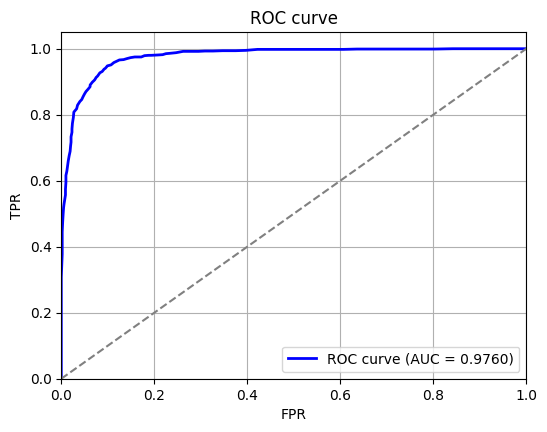

Cross-Validation
Accuracy: 0.9123 ± 0.0066
Precision: 0.9125 ± 0.0099
Recall: 0.9128 ± 0.0115
F1 Score: 0.9126 ± 0.0079
Latex: baroque\_ref & 0.9123 ± 0.0066 & 0.9125 ± 0.0099 & 0.9128 ± 0.0115 & 0.9126 ± 0.0079 \\ \hline

Test
Accuracy: 0.9220
Precision: 0.9178
Recall: 0.9270
F1 Score: 0.9224
AUC: 0.9760
Latex: baroque\_ref & 0.9220 & 0.9178 & 0.9270 & 0.9224 & 0.9760 \\ \hline

Times
Train time: 19.3180 seconds
Test time: 0.0129 miliseconds
Latex: baroque\_ref & 19.3180 & 0.0129 \\ \hline


In [14]:
random_forest('baroque', 'ref')

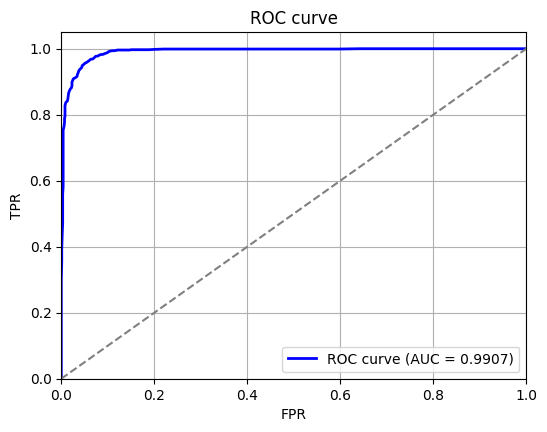

Cross-Validation
Accuracy: 0.9488 ± 0.0053
Precision: 0.9404 ± 0.0113
Recall: 0.9614 ± 0.0052
F1 Score: 0.9507 ± 0.0052
Latex: expressionism\_ref & 0.9488 ± 0.0053 & 0.9404 ± 0.0113 & 0.9614 ± 0.0052 & 0.9507 ± 0.0052 \\ \hline

Test
Accuracy: 0.9525
Precision: 0.9494
Recall: 0.9560
F1 Score: 0.9527
AUC: 0.9907
Latex: expressionism\_ref & 0.9525 & 0.9494 & 0.9560 & 0.9527 & 0.9907 \\ \hline

Times
Train time: 22.8586 seconds
Test time: 0.0122 miliseconds
Latex: expressionism\_ref & 22.8586 & 0.0122 \\ \hline


In [15]:
random_forest('expressionism', 'ref')

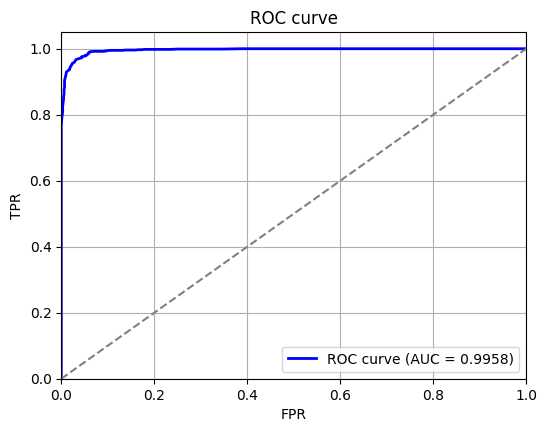

Cross-Validation
Accuracy: 0.9679 ± 0.0066
Precision: 0.9635 ± 0.0081
Recall: 0.9750 ± 0.0079
F1 Score: 0.9692 ± 0.0065
Latex: impressionism\_ref & 0.9679 ± 0.0066 & 0.9635 ± 0.0081 & 0.9750 ± 0.0079 & 0.9692 ± 0.0065 \\ \hline

Test
Accuracy: 0.9650
Precision: 0.9586
Recall: 0.9720
F1 Score: 0.9652
AUC: 0.9958
Latex: impressionism\_ref & 0.9650 & 0.9586 & 0.9720 & 0.9652 & 0.9958 \\ \hline

Times
Train time: 22.0013 seconds
Test time: 0.0100 miliseconds
Latex: impressionism\_ref & 22.0013 & 0.0100 \\ \hline


In [16]:
random_forest('impressionism', 'ref')

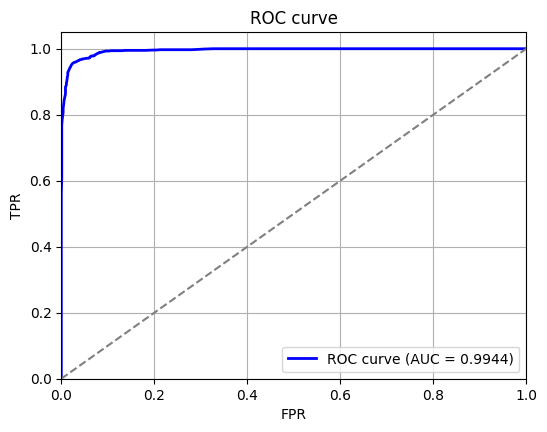

Cross-Validation
Accuracy: 0.9652 ± 0.0065
Precision: 0.9567 ± 0.0085
Recall: 0.9768 ± 0.0062
F1 Score: 0.9666 ± 0.0063
Latex: post_impressionism\_ref & 0.9652 ± 0.0065 & 0.9567 ± 0.0085 & 0.9768 ± 0.0062 & 0.9666 ± 0.0063 \\ \hline

Test
Accuracy: 0.9595
Precision: 0.9500
Recall: 0.9700
F1 Score: 0.9599
AUC: 0.9944
Latex: post_impressionism\_ref & 0.9595 & 0.9500 & 0.9700 & 0.9599 & 0.9944 \\ \hline

Times
Train time: 23.5608 seconds
Test time: 0.0108 miliseconds
Latex: post_impressionism\_ref & 23.5608 & 0.0108 \\ \hline


In [17]:
random_forest('post_impressionism', 'ref')

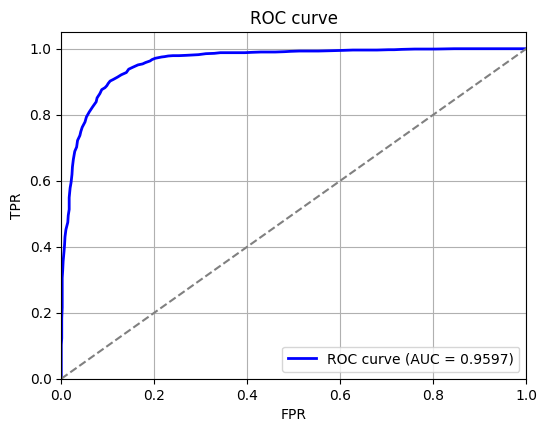

Cross-Validation
Accuracy: 0.8954 ± 0.0083
Precision: 0.8778 ± 0.0130
Recall: 0.9245 ± 0.0108
F1 Score: 0.9004 ± 0.0081
Latex: realism\_ref & 0.8954 ± 0.0083 & 0.8778 ± 0.0130 & 0.9245 ± 0.0108 & 0.9004 ± 0.0081 \\ \hline

Test
Accuracy: 0.8965
Precision: 0.8831
Recall: 0.9140
F1 Score: 0.8983
AUC: 0.9597
Latex: realism\_ref & 0.8965 & 0.8831 & 0.9140 & 0.8983 & 0.9597 \\ \hline

Times
Train time: 18.0338 seconds
Test time: 0.0168 miliseconds
Latex: realism\_ref & 18.0338 & 0.0168 \\ \hline


In [18]:
random_forest('realism', 'ref')

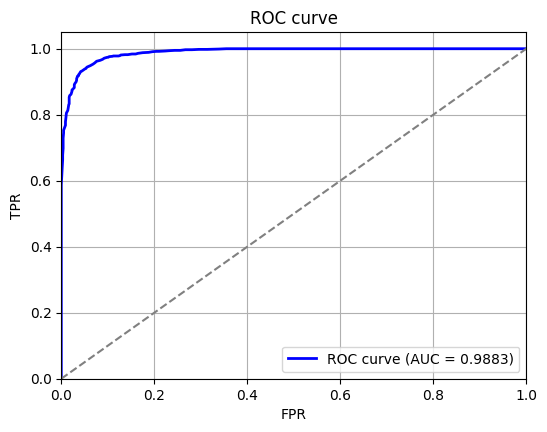

Cross-Validation
Accuracy: 0.9475 ± 0.0069
Precision: 0.9446 ± 0.0118
Recall: 0.9516 ± 0.0067
F1 Score: 0.9480 ± 0.0068
Latex: renaissance\_ref & 0.9475 ± 0.0069 & 0.9446 ± 0.0118 & 0.9516 ± 0.0067 & 0.9480 ± 0.0068 \\ \hline

Test
Accuracy: 0.9435
Precision: 0.9466
Recall: 0.9400
F1 Score: 0.9433
AUC: 0.9883
Latex: renaissance\_ref & 0.9435 & 0.9466 & 0.9400 & 0.9433 & 0.9883 \\ \hline

Times
Train time: 24.1603 seconds
Test time: 0.0116 miliseconds
Latex: renaissance\_ref & 24.1603 & 0.0116 \\ \hline


In [19]:
random_forest('renaissance', 'ref')

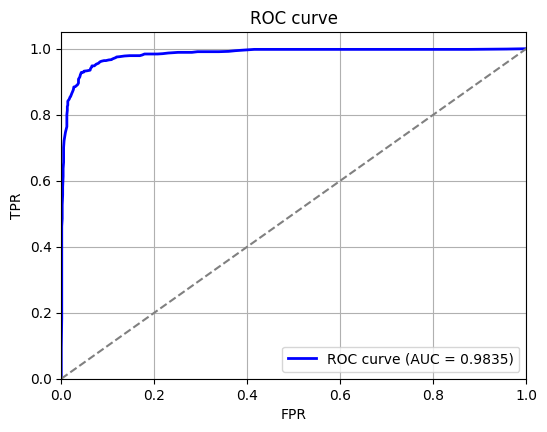

Cross-Validation
Accuracy: 0.9478 ± 0.0097
Precision: 0.9507 ± 0.0102
Recall: 0.9494 ± 0.0122
F1 Score: 0.9500 ± 0.0090
Latex: romanticism\_ref & 0.9478 ± 0.0097 & 0.9507 ± 0.0102 & 0.9494 ± 0.0122 & 0.9500 ± 0.0090 \\ \hline

Test
Accuracy: 0.9395
Precision: 0.9356
Recall: 0.9440
F1 Score: 0.9398
AUC: 0.9835
Latex: romanticism\_ref & 0.9395 & 0.9356 & 0.9440 & 0.9398 & 0.9835 \\ \hline

Times
Train time: 23.6022 seconds
Test time: 0.0122 miliseconds
Latex: romanticism\_ref & 23.6022 & 0.0122 \\ \hline


In [20]:
random_forest('romanticism', 'ref')

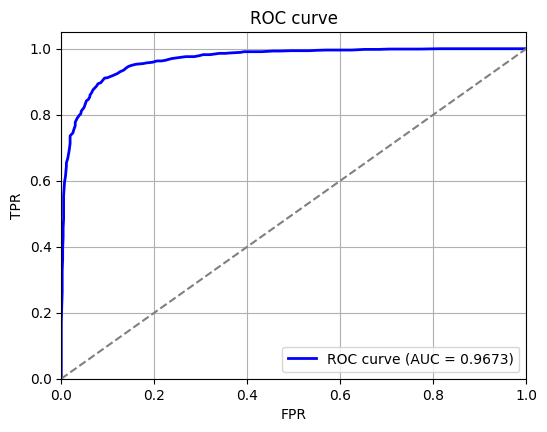

Cross-Validation
Accuracy: 0.8992 ± 0.0077
Precision: 0.9020 ± 0.0136
Recall: 0.9035 ± 0.0112
F1 Score: 0.9026 ± 0.0078
Latex: surrealism\_ref & 0.8992 ± 0.0077 & 0.9020 ± 0.0136 & 0.9035 ± 0.0112 & 0.9026 ± 0.0078 \\ \hline

Test
Accuracy: 0.9090
Precision: 0.9074
Recall: 0.9110
F1 Score: 0.9092
AUC: 0.9673
Latex: surrealism\_ref & 0.9090 & 0.9074 & 0.9110 & 0.9092 & 0.9673 \\ \hline

Times
Train time: 22.2289 seconds
Test time: 0.0135 miliseconds
Latex: surrealism\_ref & 22.2289 & 0.0135 \\ \hline


In [21]:
random_forest('surrealism', 'ref')

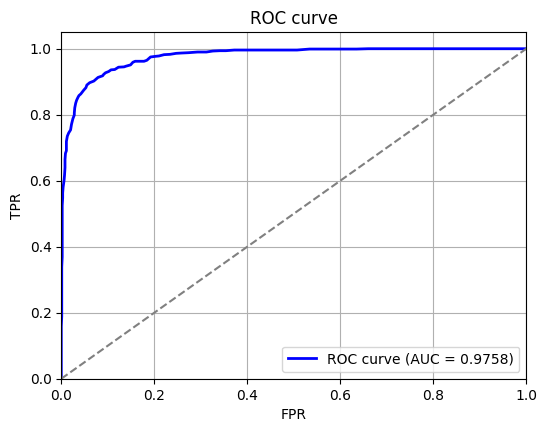

Cross-Validation
Accuracy: 0.9156 ± 0.0093
Precision: 0.9179 ± 0.0109
Recall: 0.9182 ± 0.0118
F1 Score: 0.9180 ± 0.0090
Latex: ukiyo-e\_ref & 0.9156 ± 0.0093 & 0.9179 ± 0.0109 & 0.9182 ± 0.0118 & 0.9180 ± 0.0090 \\ \hline

Test
Accuracy: 0.9155
Precision: 0.9102
Recall: 0.9220
F1 Score: 0.9160
AUC: 0.9758
Latex: ukiyo-e\_ref & 0.9155 & 0.9102 & 0.9220 & 0.9160 & 0.9758 \\ \hline

Times
Train time: 17.8553 seconds
Test time: 0.0135 miliseconds
Latex: ukiyo-e\_ref & 17.8553 & 0.0135 \\ \hline


In [22]:
random_forest('ukiyo-e', 'ref')

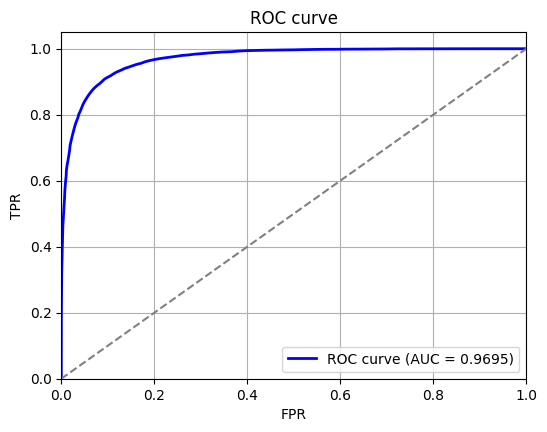

Cross-Validation
Accuracy: 0.9048 ± 0.0036
Precision: 0.9084 ± 0.0033
Recall: 0.9063 ± 0.0044
F1 Score: 0.9073 ± 0.0033
Latex: all\_ref & 0.9048 ± 0.0036 & 0.9084 ± 0.0033 & 0.9063 ± 0.0044 & 0.9073 ± 0.0033 \\ \hline

Test
Accuracy: 0.9074
Precision: 0.9072
Recall: 0.9077
F1 Score: 0.9075
AUC: 0.9695
Latex: all\_ref & 0.9074 & 0.9072 & 0.9077 & 0.9075 & 0.9695 \\ \hline

Times
Train time: 308.8948 seconds
Test time: 0.0284 miliseconds
Latex: all\_ref & 308.8948 & 0.0284 \\ \hline


In [23]:
random_forest('all', 'ref')